In [ ]:
!pip install torchsummary

In [3]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

In [ ]:
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [ ]:
print(diseases)

['Tomato___Early_blight', 'Apple___Black_rot', 'Tomato___healthy', 'Peach___healthy', 'Strawberry___healthy', 'Apple___healthy', 'Tomato___Late_blight', 'Corn_(maize)___healthy', 'Corn_(maize)___Common_rust_', 'Pepper,_bell___Bacterial_spot', 'Soybean___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Strawberry___Leaf_scorch', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Potato___healthy', 'Tomato___Tomato_mosaic_virus', 'Orange___Haunglongbing_(Citrus_greening)', 'Corn_(maize)___Northern_Leaf_Blight', 'Pepper,_bell___healthy', 'Tomato___Septoria_leaf_spot', 'Grape___Esca_(Black_Measles)', 'Tomato___Target_Spot', 'Tomato___Leaf_Mold', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Cherry_(including_sour)___Powdery_mildew', 'Apple___Cedar_apple_rust', 'Raspberry___healthy', 'Grape___healthy', 'Apple___Apple_scab', 'Peach___Bacterial_spot', 'Cherry_(including_sour)___healthy', 'Tomato___Bacterial_spot', 'Grape___Black_rot', 'Squash___Powdery_mildew', 'Potato___Early_blight

In [ ]:
len_of_diseases = len(diseases)
print("Number of classes: {}".format(len_of_diseases))

Number of classes: 38


In [ ]:
# number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

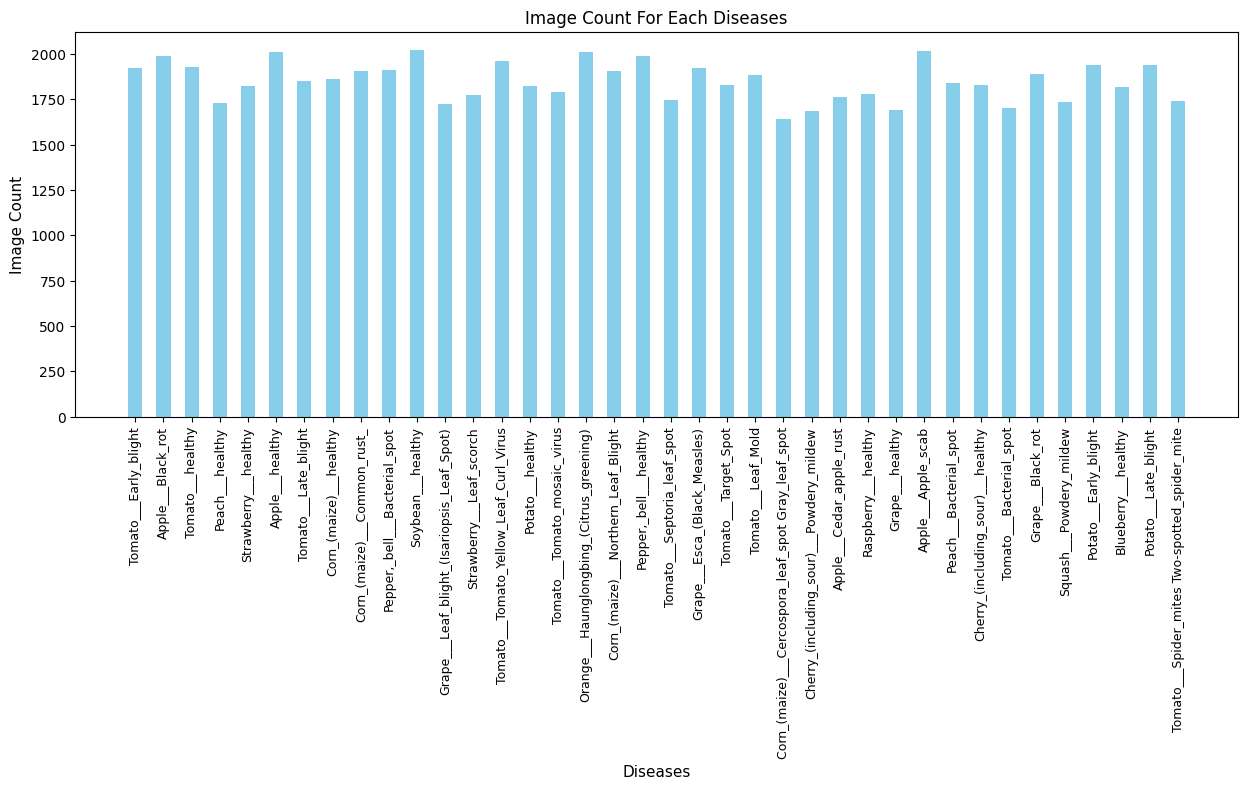

In [ ]:
# plotting number of images for each disease
index = [n for n in range(len_of_diseases)]
plt.figure(figsize=(15, 5))
plt.bar(index, [count for count in nums.values()], color='skyblue', width=0.5)
plt.xlabel('Diseases', fontsize=11)
plt.ylabel('Image Count', fontsize=11)
plt.xticks(index, diseases, fontsize=9, rotation=90)
plt.title('Image Count For Each Diseases')
plt.show()

In [ ]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [ ]:
# shape
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [ ]:
# setting the seed value and batch size
batch_size = 32
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
# dataloaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [ ]:
# show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [ ]:
# images for first batch of training
show_batch(train_dl)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # predictions
        loss = F.cross_entropy(out, labels) # loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # prediction
        loss = F.cross_entropy(out, labels)  # loss
        acc = accuracy(out, labels)          # accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


In [ ]:
# convolution block
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet9 architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len_of_diseases), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [ ]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()


        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [ ]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 47.2 s, sys: 3.43 s, total: 50.7 s
Wall time: 44.8 s


[{'val_loss': tensor(3.6400, device='cuda:0'), 'val_accuracy': tensor(0.0282)}]

In [ ]:
epochs = 2
lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam

In [ ]:
%%time
history += fit_OneCycle(epochs, lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=optimizer)

Epoch [0], last_lr: 0.00812, train_loss: 0.2987, val_loss: 0.4774, val_acc: 0.8445
Epoch [1], last_lr: 0.00000, train_loss: 0.0988, val_loss: 0.0297, val_acc: 0.9912
CPU times: user 10min 11s, sys: 11min 2s, total: 21min 13s
Wall time: 20min 4s


In [1]:
val_acc = []
val_loss = []
train_loss = []

for i in history:
    val_acc.append(i['val_acc'])
    val_loss.append(i['val_loss'])
    train_loss.append(i.get('train_loss'))

<ipython-input-7-d7029f1ef6c3>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epoch_count, train_loss, 'r--', color= 'yellow')
<ipython-input-7-d7029f1ef6c3>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epoch_count, val_loss, '--bo',color= 'darkblue', linewidth = '2.5', label='line with marker')


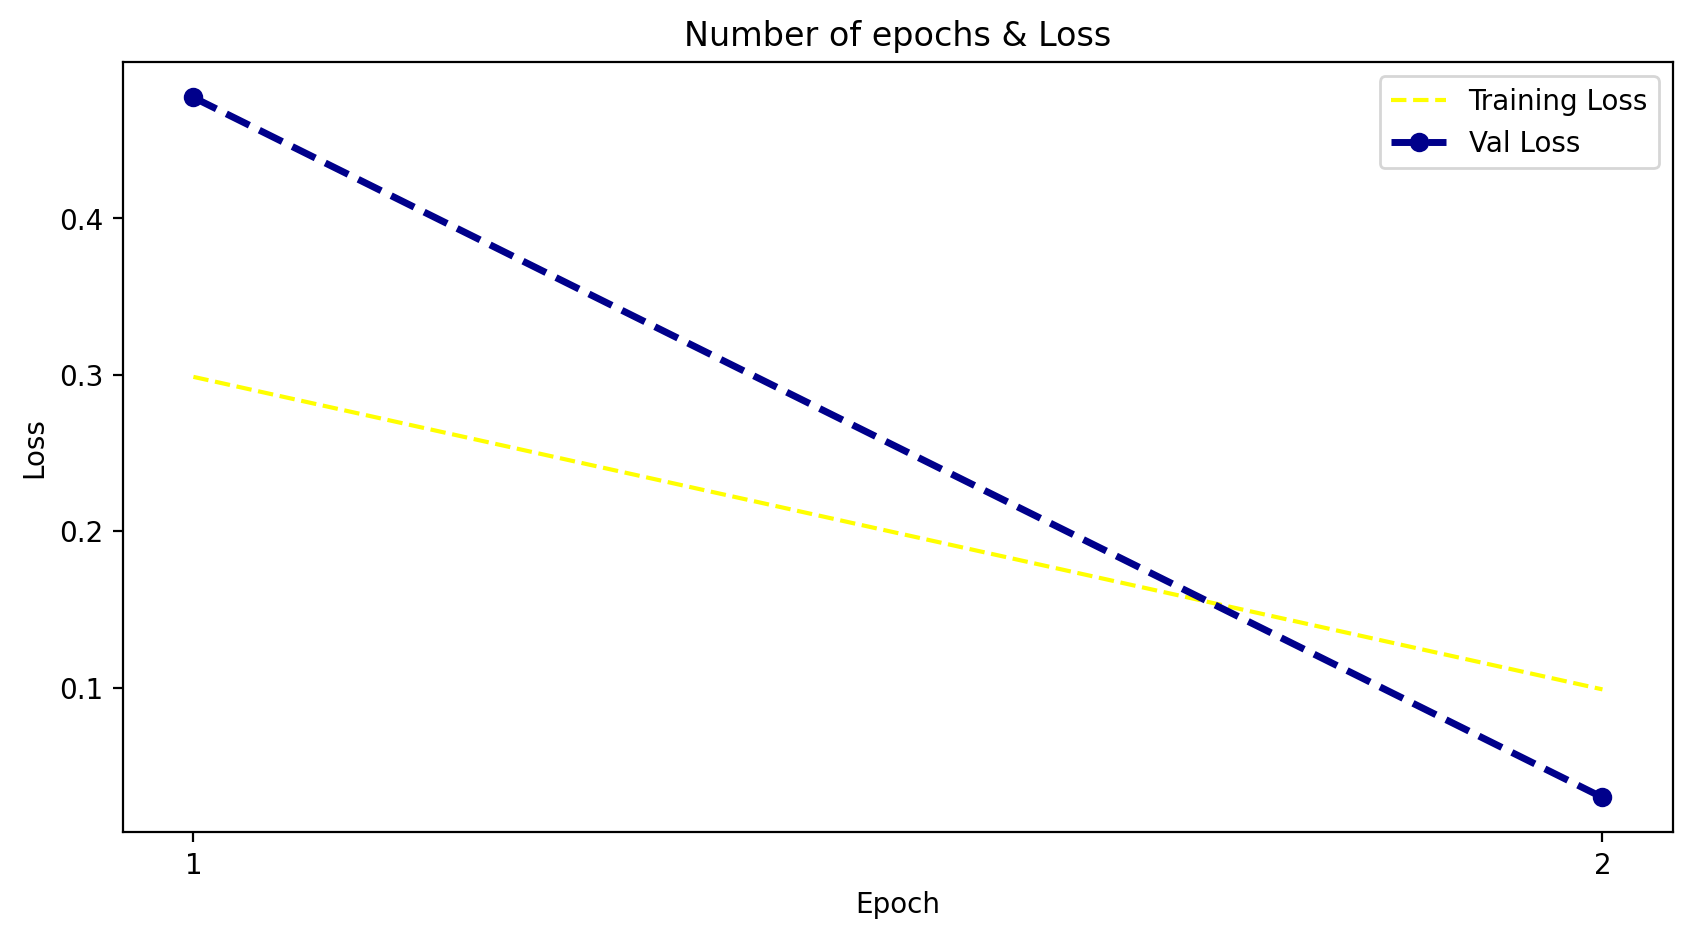

In [7]:
epoch_count = range(1,epochs + 1)
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, train_loss, 'r--', color= 'yellow')
plt.plot(epoch_count, val_loss, '--bo',color= 'darkblue', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,epochs + 1,1))
plt.show();

<ipython-input-8-22e3e4cf0f4b>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epoch_count, val_acc, '--bo',color= 'skyblue', linewidth = '2.5', label='line with marker')


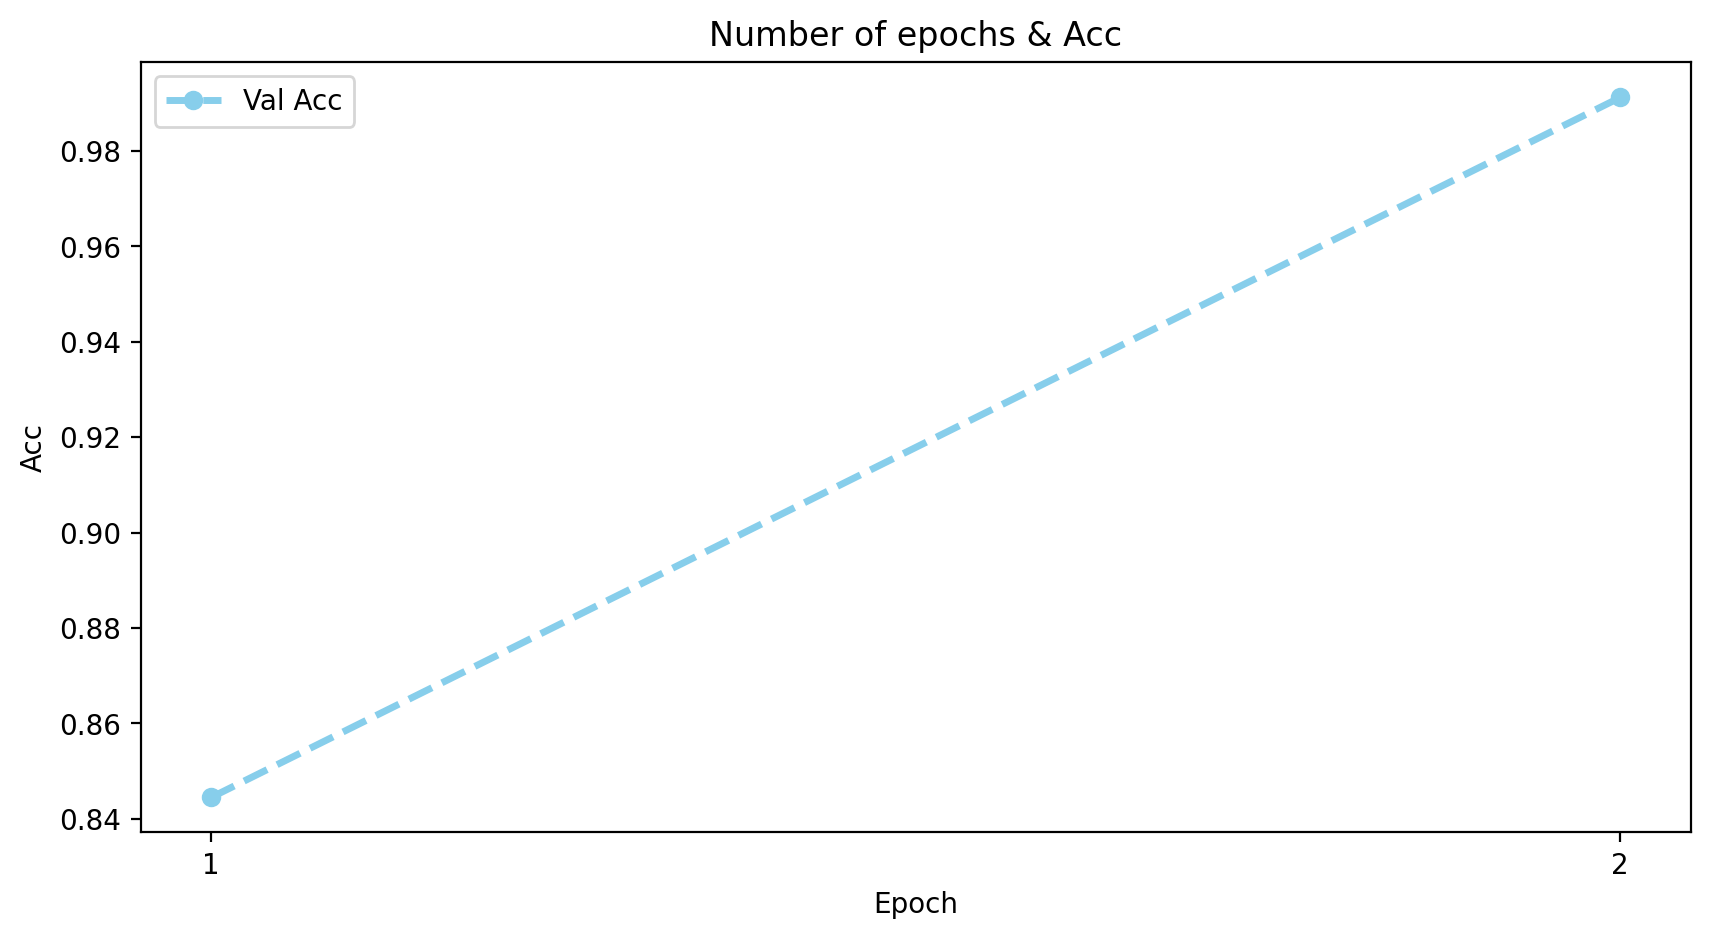

In [8]:
epoch_count = range(1,epochs + 1)
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, val_acc, '--bo',color= 'skyblue', linewidth = '2.5', label='line with marker')
plt.legend(['Val Acc'])
plt.title('Number of epochs & Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.xticks(np.arange(1,epochs + 1,1))
plt.show();